# ResNet50 Transfer Learning Example Using Fruit Data

This is an example showing how an existing, fully trained CNN, can be used for a different classification task. This is achieved removing the existing fully connected layer, the head, from the model, and replacing it with a new one. All the existing weights of the CNN are kept, while the new fully connected layer is trained. ResNet50 from tensorflow is used as the base network, and the training is done using the Fruits 360 data from https://www.kaggle.com/moltean/fruits.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Reduce TF verbosity
import tensorflow as tf
tf.get_logger().setLevel('INFO') # Reduce TF verbosity
print(f"tensorflow version: {tf.__version__}")

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import utils
import gdown
import zipfile

tensorflow version: 2.6.0


In [2]:
def download_fruit_data():
    url = 'https://drive.google.com/file/d/1_Yi9Q3BqsrogWHQ0TLEq-6GcsjnJjW4o/view?usp=sharing'
    output = './large_files/fruits-360.zip'
    if not os.path.exists('./large_files/fruits-360'):
        gdown.download(url, output, quiet=False, fuzzy=True)
        with zipfile.ZipFile('./large_files/fruits-360.zip', 'r') as zip_ref:
            zip_ref.extractall('./large_files')

def mkdir(p):
    if not os.path.exists(p):
        os.makedirs(p)

def link(src, dst):
    if not os.path.exists(dst):
        os.symlink(src, dst, target_is_directory=True)

In [3]:
# Download the fruit data
download_fruit_data()

In [4]:
# Paths to training and test data

src_path_training = os.path.join(os.path.realpath('.'), 'large_files', 'fruits-360', 'Training')
src_path_test = os.path.join(os.path.realpath('.'), 'large_files', 'fruits-360', 'Test')

In [5]:
image_size = [100, 100]

training_images = glob(src_path_training + '/*/*.jp*g')
test_images = glob(src_path_test + '/*/*.jp*g')
folders = glob(src_path_training + '/*')

print(f'Number of training images: {len(training_images)}')
print(f'Number of testing images: {len(test_images)}')
print(f'Number of classes: {len(folders)}')

Number of training images: 67692
Number of testing images: 22688
Number of classes: 131


In [6]:
# Load ResNet 50 with weights, but without the head/top
resnet = ResNet50(input_shape=image_size + [3], weights='imagenet', include_top=False)

# Freeze the layers
for layer in resnet.layers:
    layer.trainable = False

x = Flatten()(resnet.output)

# New head
prediction = Dense(len(folders), activation='softmax')(x)

# Create the model
model = Model(inputs=resnet.input, outputs=prediction)

# Output summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [7]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

# Image augmentation using ImageDataGenerator
gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Found 67692 images belonging to 131 classes.
Image classes
{'Apple Braeburn': 0, 'Apple Crimson Snow': 1, 'Apple Golden 1': 2, 'Apple Golden 2': 3, 'Apple Golden 3': 4, 'Apple Granny Smith': 5, 'Apple Pink Lady': 6, 'Apple Red 1': 7, 'Apple Red 2': 8, 'Apple Red 3': 9, 'Apple Red Delicious': 10, 'Apple Red Yellow 1': 11, 'Apple Red Yellow 2': 12, 'Apricot': 13, 'Avocado': 14, 'Avocado ripe': 15, 'Banana': 16, 'Banana Lady Finger': 17, 'Banana Red': 18, 'Beetroot': 19, 'Blueberry': 20, 'Cactus fruit': 21, 'Cantaloupe 1': 22, 'Cantaloupe 2': 23, 'Carambula': 24, 'Cauliflower': 25, 'Cherry 1': 26, 'Cherry 2': 27, 'Cherry Rainier': 28, 'Cherry Wax Black': 29, 'Cherry Wax Red': 30, 'Cherry Wax Yellow': 31, 'Chestnut': 32, 'Clementine': 33, 'Cocos': 34, 'Corn': 35, 'Corn Husk': 36, 'Cucumber Ripe': 37, 'Cucumber Ripe 2': 38, 'Dates': 39, 'Eggplant': 40, 'Fig': 41, 'Ginger Root': 42, 'Granadilla': 43, 'Grape Blue': 44, 'Grape Pink': 45, 'Grape White': 46, 'Grape White 2': 47, 'Grape White 3':

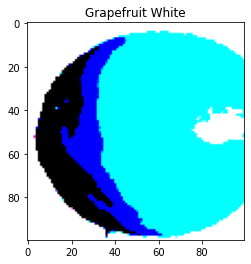

In [8]:
test_gen = gen.flow_from_directory(src_path_training, target_size=image_size)
print('Image classes')
print(test_gen.class_indices)

labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

# We expect the image to look 'strange' to the using the preprocessor
print('Displaing an image from the generator')
for x, y in test_gen:
    plt.title(labels[np.argmax(y[0])])
    print(f'Image type: {type(x[0])}')
    print(f'Image max value: {np.max(x[0])}')
    print(f'Image min value: {np.min(x[0])}')
    plt.imshow(x[0])
    plt.show()
    break

In [9]:
epochs = 5
batch_size = 32

print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')

# Training data generator
training_generator = gen.flow_from_directory(
    src_path_training,
    target_size = image_size,
    shuffle = True,
    batch_size = batch_size)

# Validation data generator
validation_generator = gen.flow_from_directory(
    src_path_test,
    target_size = image_size,
    shuffle = True,
    batch_size = batch_size)

# Train the model
r = model.fit(
    training_generator,
    validation_data = validation_generator,
    epochs = epochs,
    steps_per_epoch = len(training_images) // batch_size,
    validation_steps = len(test_images) // batch_size
)

Epochs: 5
Batch size: 32
Found 67692 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.
Epoch 1/5
2115/2115 [==============================] - 221s 103ms/step - loss: 1.5001 - accuracy: 0.9042 - val_loss: 2.3608 - val_accuracy: 0.9116
Epoch 2/5
2115/2115 [==============================] - 217s 103ms/step - loss: 0.6753 - accuracy: 0.9682 - val_loss: 3.6578 - val_accuracy: 0.9142
Epoch 3/5
2115/2115 [==============================] - 216s 102ms/step - loss: 0.5974 - accuracy: 0.9774 - val_loss: 2.6261 - val_accuracy: 0.9420
Epoch 4/5
2115/2115 [==============================] - 216s 102ms/step - loss: 0.5084 - accuracy: 0.9832 - val_loss: 2.3344 - val_accuracy: 0.9501
Epoch 5/5
2115/2115 [==============================] - 223s 105ms/step - loss: 0.4257 - accuracy: 0.9865 - val_loss: 2.4118 - val_accuracy: 0.9558


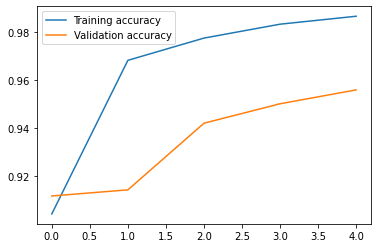

In [10]:
# Plot accuracy
plt.plot(r.history['accuracy'], label='Training accuracy')
plt.plot(r.history['val_accuracy'], label='Validation accuracy')
plt.legend()

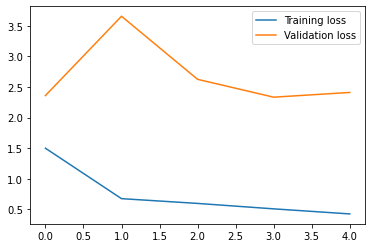

In [11]:
# Plot loss
plt.plot(r.history['loss'], label='Training loss')
plt.plot(r.history['val_loss'], label='Validation loss')
plt.legend()

Creating a confusion matrix
Found 67692 images belonging to 131 classes.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 2115/2116 [04:41<00:00,  7.50it/s]


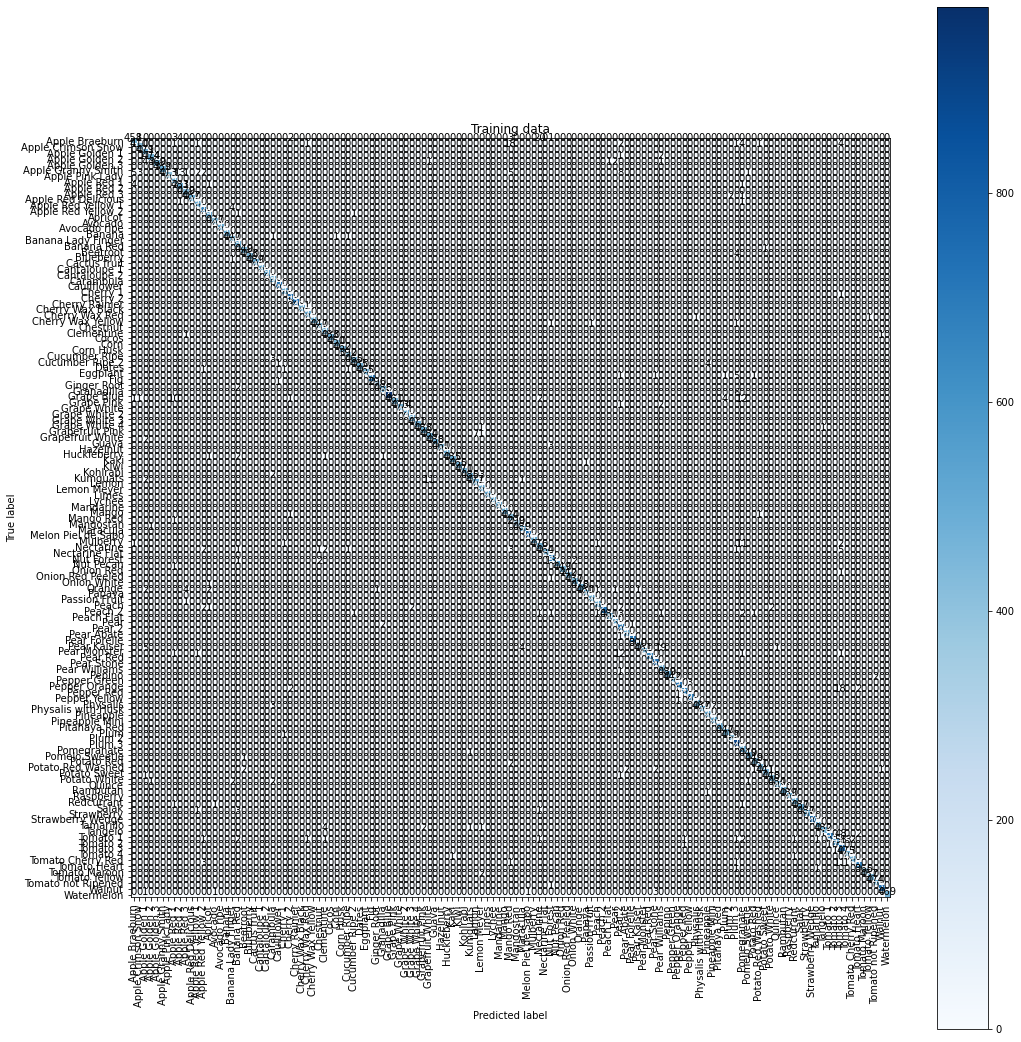

In [12]:
# Create and display confusion matrix for the training data
cm, class_names_training = utils.get_confusion_matrix(model, gen, src_path_training, image_size)
utils.plot_confusion_matrix(cm, class_names_training, 'Training data')

Creating a confusion matrix
Found 22688 images belonging to 131 classes.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 708/709 [01:30<00:00,  7.80it/s]


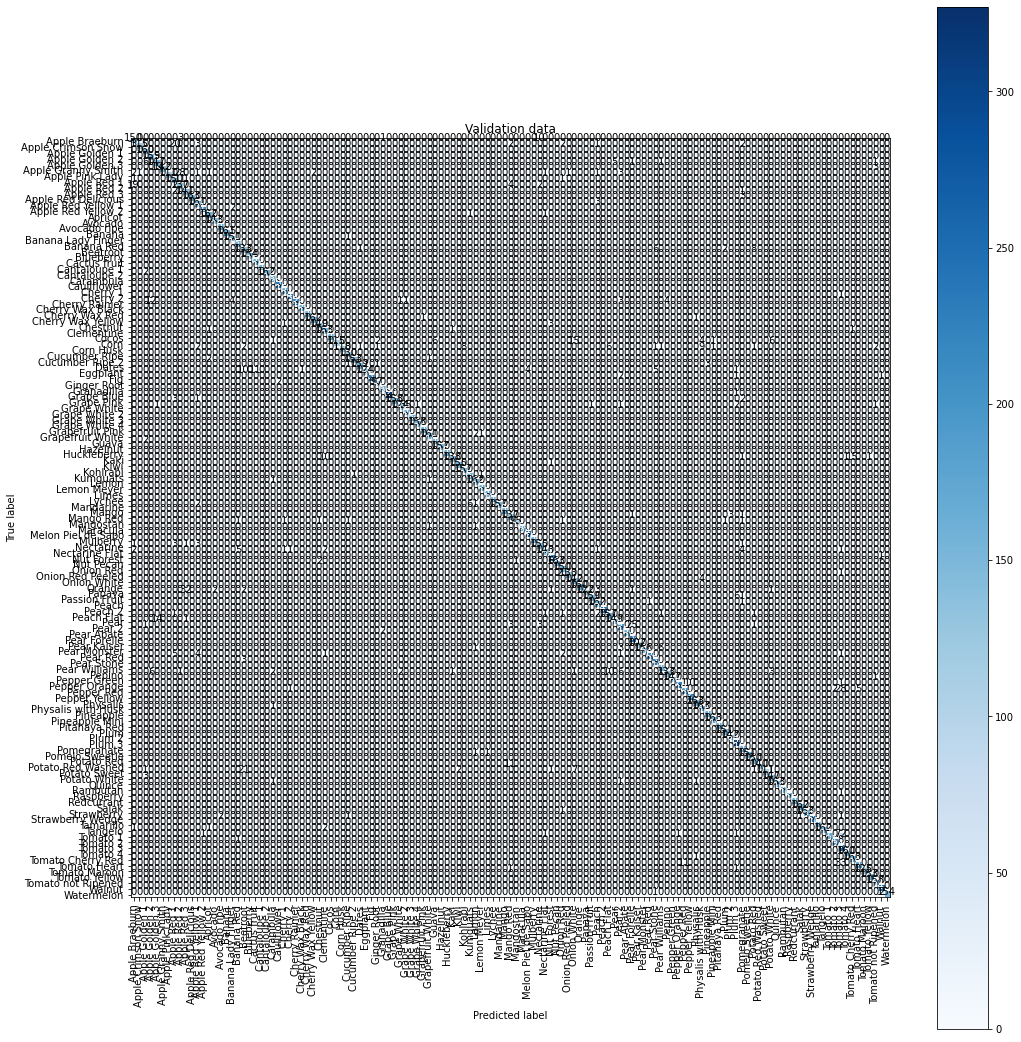

In [13]:
# Create and display confusion matrix for the validation data
validation_cm, class_names_validation = utils.get_confusion_matrix(model, gen, src_path_test, image_size)
utils.plot_confusion_matrix(validation_cm, class_names_validation, 'Validation data')